# RNN이란?
RNN은 "Recurrent Neural Network"의 약자로, 순환 신경망을 나타냅니다. 이는 시퀀스 데이터나 시계열 데이터와 같이 순서가 있는 데이터를 처리하는 데 주로 사용되는 딥러닝 아키텍처입니다. RNN은 입력 데이터의 현재 상태를 처리하는 동안 이전 상태의 정보를 활용하여 내부적으로 순환하는 구조를 가지고 있습니다.

RNN은 다음과 같은 특징을 가지고 있습니다:

1. **순환 구조**: RNN은 입력 데이터를 한 단계씩 처리하면서 이전 단계의 출력을 현재 단계의 입력으로 사용합니다. 이로 인해 시퀀스 데이터의 패턴과 의존성을 학습할 수 있습니다.

2. **내부 상태(Hidden State)**: RNN은 내부 상태(또는 은닉 상태)를 가지고 있으며, 이전 상태에서의 정보를 저장하고 새로운 입력을 처리하는 동안에 업데이트됩니다. 내부 상태는 시퀀스 데이터의 정보를 유지하고 전달하는 역할을 합니다.

3. **시간에 따른 가중치 공유**: RNN은 같은 네트워크의 각 시간 단계에서 동일한 가중치를 공유합니다. 이는 데이터의 순서적 특성을 적절하게 캡처하는 데 도움이 됩니다.

그러나 기본적인 RNN은 장기 의존성(Long-Term Dependencies)을 캡처하는 데 어려움이 있습니다. 이를 해결하기 위해 LSTM(Long Short-Term Memory)과 GRU(Gated Recurrent Unit)와 같은 변형된 RNN 아키텍처가 개발되었습니다. 이러한 변형된 아키텍처는 장기 의존성 문제를 완화하면서 더 긴 시퀀스 정보를 캡처할 수 있습니다.

RNN과 그 변형들은 자연어 처리, 음성 인식, 기계 번역, 주가 예측 등 다양한 영역에서 사용되며, 시퀀스 데이터를 처리하고 그 내부 패턴을 학습하는 데 유용합니다.

import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import matplotlib 

matplotlib.rc('font', family='AppleGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. 입력과 출력 시퀀스
1. sequence-to-sequence network : 입력 시퀀스를 받아 출력 시퀀스를 만들 수 있다.
   - 주식 가격 같은 시계열 데이터를 에측하는 데 유용
   - 최근 N일치의 주식가격을 주입하면 네트워크는 각 입력값보다 하루 앞선 가격을 출력해야 한다. 즉, N-1일 전부터 내일까지
2. sequence-to-vector network : 입력 시퀀스를 네트워크에 주입하고, 마지막을 제외한 모든 출력을 무시할 수 있다.
   - 영와 리뷰에 있는 연속된 단어를 주입하면 네트워크는 감정 점수를 출력한다. -1(싫음)에서 +1(좋음)까지
3. vector-to-sequence : 각 타임 스텝에서 하나의 입력 벡터를 반복해서 네트워크에 주입하고, 하나의 시퀀스를 출력할 수 있다.
   - 이미지를 입력하여 이미지에 대한 캡션을 출력할 수 있다.
4. 인코더라 부르는 sequence-to-vector network 뒤에 디코더라 부르는 vector-to-sequence network를 연결할 수 있다.
   - 한 언어의 문장을 다른 언어로 번역하는 데 사용할 수 있다. 한 언어의 문장을 네트워크에 주입하면 인코더는 이를 벡터 표현으로 변환하고, 그다음 디코더가 이 벡터를 다른 언어의 문장으로 디코딩한다.
   - 인코더-디코더라 부르는 이런 이중 단게 모델은 하나의 시퀀스-투-시퀀스 RNN을 사용하여 번역하는 것보다 훨씬 더 잘 작동한다. 문장의 마지막 단어가 번역의 첫 번째 단어에 영향을 줄 수 있기 때문이다. 그래서 번역하기 전에 전체 문장이 주입될 때까지 기다릴 필요가 있다.

In [1]:
# generate dataset
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # [배치크기, 타임 스탭 수, 1] 크기의 넘파이 배열. 즉, 단변량 시계열 반환
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
import numpy as np
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1) 
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

X_train은 [7000, 50, 1]크기의 배열로 7000개의 시계열을 담고있다.   
X_valid는 2000개, X_test는 1000개를 담고 있다.   
각 시계열마다 하나의 값을 예측해야 하기 때문에 탁시은 열 벡터이다. 즉, y_train은 [7000, 1] 크기이다.

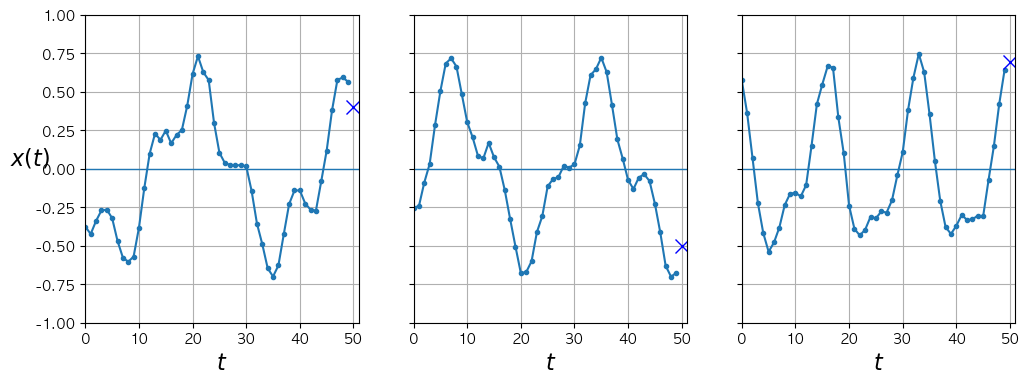

In [7]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None)) # 예측

plt.show()

# 2. 기준 성능
방법 1. naive forcasting     
: 가장 간단한 방법. 각 시계열의 마지막 값을 그대로 예측하는 것이다.
- 이 성능을 넘는 것이 어렵다. 위의 경우 mse는 0.02 이다.

In [9]:
import keras 

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

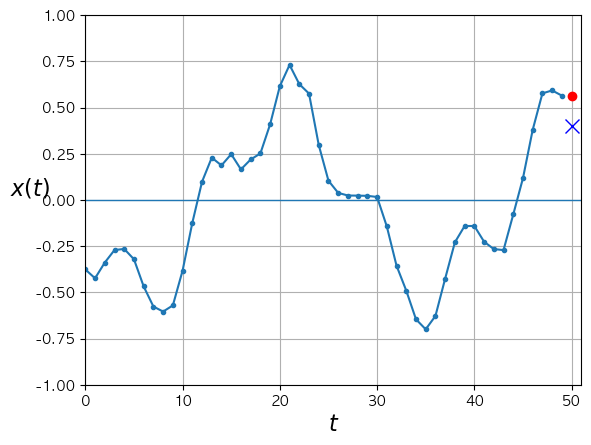

In [10]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

방법 2. 완전 연결 네트워크 사용    
이 네크워크는 입력마다 1차원 특성 배열을 기대하기 때문에 Flatten 층을 추가해야 함.    
MSE가 0.004로 줄어들었다.

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20


2023-08-15 15:00:55.841559: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


219/219 [==============================] - 1s 5ms/step - loss: 0.0899 - val_loss: 0.0475
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0344 - val_loss: 0.0253
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0202 - val_loss: 0.0169
Epoch 4/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0121 - val_loss: 0.0115
Epoch 6/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 8/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 10/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 11/2

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0044


0.004432183224707842

# 3. 간단한 RNN 구현
RNN은 어떤 길이의 타임 스켑도 처리할 수 있기 때문에 이전 모델과 달리 입력 시퀀스의 길이를 지정할 필요가 없다. 따라서 input_shape=[None, 1]으로 한다.    

기본적으로 SimpleRNN 층은 하이퍼볼릭 탄젠트 활성함수를 사용한다. 때문에 예측된 값이 -1 ~ +1 사이 범위에 놓인다.   
다른 활성함수를 사용하려면 출력층을 Dense 층으로 바꿔야 한다. 이렇게 바꾸려면 마지막 순환 층에 return_sequence=True를 제거해야 한다.(출력층이 아니라 마지막 순환 층의 return_sequence=True를 제거)

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # 하나의 뉴런으로 이루어진 하나의 층
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 125s 571ms/step - loss: 0.1092 - val_loss: 0.0401
Epoch 2/20
219/219 [==============================] - 119s 543ms/step - loss: 0.0322 - val_loss: 0.0267
Epoch 3/20
219/219 [==============================] - 125s 573ms/step - loss: 0.0233 - val_loss: 0.0203
Epoch 4/20
219/219 [==============================] - 126s 577ms/step - loss: 0.0186 - val_loss: 0.0167
Epoch 5/20
219/219 [==============================] - 126s 573ms/step - loss: 0.0158 - val_loss: 0.0145
Epoch 6/20
219/219 [==============================] - 125s 573ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 7/20
219/219 [==============================] - 125s 572ms/step - loss: 0.0129 - val_loss: 0.0120
Epoch 8/20
219/219 [==============================] - 128s 582ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 9/20
219/219 [==============================] - 124s 567ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 10/20
219/219 [==============================] - 126s 577m

# 4. Deep RNN
RNN은 셀을 여러 층으로 쌓는 것이 일반적이다. 이것이 Deep RNN이다.   
keras로 deep RNN을 구현하는 것은 간단하다. 그냥 순환 층을 쌓으면 된다.    
LSTM 층이나 GRU 층 같은 다른 종류의 순환 층을 추가할 수 있다.
> 모든 순환 층에서 return_sequence=True로 설정헤야 한다.
> (마지막 출력만 관심 대상이라면 마지막 층을 제외하고 설정)
> 그렇지 않으면 모든 타임 스텝에 대한 출력을 담은 3D 배열이 아니라 마지막 타임 스텝의 출력만 담은 2D 배열이 출력되고 다음 순환 층이 3D 형태로 시퀀스를 받지 못하기 때문에 작동하지 못한다.     

## 방법 1. SimpleRNN 여러 개 쌓기

In [17]:
np.random.seed(42)
tf.random.set_seed(42)

# SimpleRNN layer를 여러 개 쌓아 deep RNN 만들기
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 610s 3s/step - loss: 0.0489 - val_loss: 0.0102
Epoch 2/20
219/219 [==============================] - 599s 3s/step - loss: 0.0081 - val_loss: 0.0062
Epoch 3/20
219/219 [==============================] - 589s 3s/step - loss: 0.0056 - val_loss: 0.0047
Epoch 4/20
 64/219 [=======>......................] - ETA: 6:59 - loss: 0.0048

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_valid, y_valid)

## 방법 2. second SimpleRNN layer return only the last output:   
기본적으로 SimpleRNN 층은 하이퍼볼릭 탄젠트 활성함수를 사용한다. 때문에 예측된 값이 -1 ~ +1 사이 범위에 놓인다.   
다른 활성함수를 사용하려면 출력층을 Dense 층으로 바꿔야 한다. 이렇게 바꾸려면 마지막 순환 층에 return_sequence=True를 제거해야 한다.(출력층이 아니라 마지막 순환 층의 return_sequence=True를 제거)    
아래 모델은 빠르게 수렴하고 성능도 좋다. 또한 출력층의 활성함수를 원하는 함수로 바꿀 수 있다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), #return_sequence=True를 제거
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
model.evaluate(X_valid, y_valid)

# 5. Forecasting Several Steps Ahead¶
타깃을 바꾸어 여러 타임 스텝 앞의 값을 예측할 수 있다. 예를 들어, 1 스텝 앞이 아니라 10 스텝 앞의 값으로 타깃을 바꾸면 된다.   

## 방법 1. Pretrained model 사용
Pretrained model을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가한다. 예측된 값이 실제로 발결된 것처럼 바꾸는 것이다. 이 모델을 사용해 다시 다음 값을 예측하는 식이다.     

미래의 타임 스텝은 오차가 누적될 수 있기 때문에 바로 다음 타음 스텝을 예측하는 것보다 

In [ ]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

## 방법 2. RNN을 훈련하여 다음 값 10개를 한 번에 예측
sequence-to -vector 모델을 사용하지만 1개다 아니라 값 10개를 출력한다. 먼저 타깃을 다음 10개의 값이 담긴 벡터로 바꿔야 한다.

In [ ]:
# regenerate the sequences with 9 more time steps.
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
# predict the next 10 values one by one
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [ ]:
# compare this performance with some baselines: naive predictions and a simple linear model:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

### 선형 모델

In [ ]:
### Model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10) # 10개의 유닛을 가진 출력층 필요
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

### RNN 모델

In [ ]:
# RNN Model
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
# pred
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

## 방법 3. 
마지막 스텝에서만 다음 값 10개를 예측하도록 훈련하는 대신 모든 타임 스텝에서 다음 값 10개를 예측하도록 모델을 훈련할 수 있다. 즉 sequence-to-sequence RNN을 sequence-to-vector RNN으로 바꿀 수 있다.   
이 방식의 장점은 마지막 차임 스텝에서의 출력뿐만 아니라 모든 타임 스텝에서 RNN 출력에 대한 항이 손실에 포함된다는 것이다. 즉 더 많은 오차 그레디언트가 모델로 흐른다는 것이다.   

타임 스텝 0에서 모델이 타임 스텝 1에서 10까지 예측을 담은 벡터를 출력할 것이다. 그다음 타임 스텝 1에서 이 모델은 스텝 2에서 11까지 예측할 것이다. 이런 식으로 반복한다.

In [ ]:
# 타깃 준비
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

이 모델을 sequence-to-sequence로 바꾸려면 모든 순환 층에 (마지막 층도) return_sequence=True를 지정해야 한다. 그다음 모든 타임 스텝에서 출력을 Dense 층에 적용해야 한다. 이런 목적을 위해 TimeDistributed 층을 적용한다. 이 층은 다른 층을 감싸서 입력 시퀀스의 모든 타임 스텝에 이를 적용한다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

### 예측 및 평가
훈련을 위해 모든 출력에 걸쳐 MSE를 계산했지만, 평가를 위해서는 마지막 타임 스텝의 출력에 대한 MSE만을 계산하는 사용자정의 지표를 활용했다.

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

# 긴 시퀀스 다루기
긴 시퀀스로 RNN을 훈련하려면 많은 타임 스텝에 걸쳐 실행해야 하므로 매우 깊은 네트워크가 된다. 이는 그레디어트 소실 또는 폭주 문제를 야기할 수 있다.

## 1. 불안정한 그레디언트
좋은 가중치 초기화, 빠른 옵티마이저, 드롭아웃 등을 사용해 그레디언트 문제를 해결할 수 있다. 그러나 ReLu와 같은 수렴하지 않는 활성함수는 훈련하는 동안 RNN을 더욱 불안정하게 만들 수 있다. 수렴하지 않기 때문에 출력이 폭주할 수 있기 때문이다. 수렴하는 하이퍼볼릭 탄젠트 함수가 기본값이 이유도 이러한 이유 때문이다.

### 해결 방법. Layer Normalization
배치 정규화와 매우 비슷하지만 배치 차원에서 정규화하는 대신 특성 차원에 대해 정규화 한다.   
한가지 장점은 샘플에 독립적으로 타임 스텝마다 동적으로 필요한 통계를 계산할 수 있다는 것이다. 이는 훈련과 테스트에서 동일한 방식으로 작동한 다는 것을 의미한다.   

In [ ]:
from tensorflow.keras.layers import LayerNormalization

In [ ]:
# 사용자 정의 메모리 셀 정의
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states) # 하나는 출력, 하나는 새로운 은닉 상태가 됨.
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


# 위에서 정의한 함수를 층에 전달하기
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

## 2. 단기 기억 문제 해결하기
RNN을 거치면서 데이터가 변환되므로 일부 정보는 매 훈련 스텝 후 사라진다. 어느 정도 시간이 지나면 RNN의 상태는 사실상 첫 번쨰 입력의 흔적을 가지고 있지 않다.


### LSTM이란?
LSTM은 "Long Short-Term Memory"의 약자로, 장기 의존성 문제를 해결하고 시계열 데이터나 시퀀스 데이터의 장기적인 패턴을 캡처하기 위해 고안된 순환 신경망(RNN)의 한 종류입니다. LSTM은 RNN의 변형 중 하나로서, 장기적인 의존성을 효과적으로 다루기 위해 설계되었습니다.

LSTM은 다음과 같은 주요 특징을 가지고 있습니다:

1. **셀 상태(Cell State)**: LSTM은 내부적으로 셀 상태라는 중요한 구조를 가집니다. 셀 상태는 시퀀스 데이터의 장기 의존성을 유지하고 전달하는 역할을 합니다.

2. **게이트(Gates)**: LSTM은 세 개의 게이트로 구성됩니다.
   - **Forget Gate**: 이전 셀 상태로부터 어떤 정보를 삭제할지 결정합니다.
   - **Input Gate**: 현재 입력에서 어떤 정보를 셀 상태에 추가할지 결정합니다.
   - **Output Gate**: 현재 상태의 정보를 기반으로 출력을 결정합니다.

3. **셀 상태 갱신**: 게이트의 조절을 통해 셀 상태가 업데이트되며, 이를 통해 장기적인 정보를 보존하거나 잊어버릴 수 있습니다.

LSTM은 주로 자연어 처리, 음성 인식, 기계 번역과 같은 곳에서 장기적인 의존성을 필요로 하는 시퀀스 데이터를 다룰 때 사용됩니다. LSTM의 발전형으로는 GRU(Gated Recurrent Unit)가 있는데, GRU는 LSTM과 유사한 목적으로 개발된 간소화된 버전의 순환 신경망입니다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

### GRU란?
GRU는 "Gated Recurrent Unit"의 약자로, LSTM과 유사한 장기 의존성 문제를 해결하기 위해 고안된 순환 신경망(RNN) 아키텍처 중 하나입니다. LSTM과 마찬가지로 시퀀스 데이터나 시계열 데이터의 장기적인 패턴을 캡처하기 위해 사용됩니다.

GRU는 LSTM에 비해 더 간단한 구조를 가지면서도 유사한 성능을 보이는 장점이 있습니다. GRU는 LSTM의 게이트 중 일부를 합쳐서 더 간략하게 구성되었으며, 주요한 게이트인 "삭제 게이트(Reset Gate)"와 "업데이트 게이트(Update Gate)"로 구성됩니다.

1. **삭제 게이트(Reset Gate)**: 이전 상태와 현재 입력을 기반으로 어떤 정보를 삭제할지 결정합니다. 이를 통해 네트워크는 더 짧은 범위의 의존성을 학습할 수 있습니다.

2. **업데이트 게이트(Update Gate)**: 이전 상태와 현재 입력을 기반으로 어떤 정보를 업데이트하거나 유지할지 결정합니다. 이를 통해 네트워크는 장기적인 의존성을 학습하는 데 도움이 됩니다.

GRU는 LSTM에 비해 더 적은 게이트와 더 간단한 구조를 가지므로 학습이 빠르고 파라미터가 적어 메모리 사용량이 줄어들어 실제 응용에서 효율적입니다. 그러나 어떤 데이터셋이나 문제에 따라 LSTM보다 성능이 우수한 경우도 있을 수 있습니다. GRU는 주로 시계열 데이터의 모델링, 자연어 처리, 음성 처리 등 다양한 분야에서 사용됩니다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

In [ ]:
model.evaluate(X_valid, Y_valid)

#### Using One-Dimensional Convolutional Layers to Process Sequences
LSTM과 GRU 셀은 RNN의 성공주역이나 매우 제한적인 단기 기억을 가진다. 100 타임스텝 이상의 시퀀스에서 장기 패턴을 학습하는데 어려움이 있다. 이를 해결하는 한가지 방법은 1D 합성곱 층을 이용해 입력 시퀀스를 짧게 줄이는 것이다.


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

# WAVEENT이란?
WaveNet은 딥러닝 기반의 음성 합성 및 음성 처리 모델로서, 자연스러운 음성을 생성하는 데 사용되는 확률론적 생성 모델입니다. Google DeepMind에서 개발한 WaveNet은 2016년에 발표되었고, 기존의 음성 합성 기술에 비해 더욱 자연스러운 음성을 생성하는 능력으로 주목받았습니다.

WaveNet은 기본적으로 생성 모델로서, 어떤 입력 시퀀스에 대해 그 시퀀스를 만들어낼 수 있는 확률 분포를 모델링합니다. 주로 시계열 데이터인 음성 데이터를 다루기 위해 설계되었으며, 장기적인 의존성을 캡처하여 매우 자연스러운 음성을 생성할 수 있는 능력을 갖추고 있습니다.

WaveNet의 핵심 아이디어는 "카르만 필터 블록(Causal Filter Block)"이라는 구조를 사용하는 것인데, 이 블록은 이전 시점의 출력값을 현재 시점의 입력에 반영하여 장기적인 의존성을 학습합니다. 이렇게 함으로써 WaveNet은 아주 긴 시퀀스에 대한 정보를 효과적으로 학습할 수 있습니다.

WaveNet은 초기에는 음성 합성에 주로 활용되었지만, 이후 음성 변환, 음성 감정 분석, 음성 분리 등 음성 처리 분야에서도 다양한 응용이 이루어지고 있습니다. 그러나 WaveNet은 계산 비용이 높은 편이라서 실시간으로 음성 생성하기에는 어려움이 있었습니다. 이를 해결하기 위해 WaveRNN, Parallel WaveGAN 등과 같은 다양한 기술이 발전되었습니다.